In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastdataing as fd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Real, Integer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from joblib import dump, load
from scipy.stats import randint, uniform
import src.utils as ut
import warnings

2024-03-13 13:52:09.790523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 13:52:09.790618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 13:52:09.792176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 13:52:09.802037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 13:52:11.013089: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv("./data/amino_acids_hydrate_data.csv")
df

,Amino Acid,No.,MW,pI,hI,conc,C1%,C2%,C3%,P,T
0,Glycine,1,75.07,6.06,-0.4,2.05,100.0,0.0,0.0,2.94,274.45
1,Glycine,2,75.07,6.06,-0.4,2.05,100.0,0.0,0.0,4.43,278.35
2,Glycine,3,75.07,6.06,-0.4,2.05,100.0,0.0,0.0,5.93,281.15
3,Glycine,4,75.07,6.06,-0.4,2.05,100.0,0.0,0.0,7.43,283.25
4,Glycine,5,75.07,6.06,-0.4,2.05,100.0,0.0,0.0,8.97,284.85
...,...,...,...,...,...,...,...,...,...,...,...
205,Arginine,206,174.20,10.76,-4.5,5.00,100.0,0.0,0.0,9.84,285.90
206,Valine,207,117.15,6.02,4.2,5.00,100.0,0.0,0.0,4.60,278.60
207,Valine,208,117.15,6.02,4.2,5.00,100.0,0.0,0.0,6.20,281.40
208,Valine,209,117.15,6.02,4.2,5.00,100.0,0.0,0.0,7.58,283.00


In [3]:
df.drop("No. ",axis=1,inplace=True)

In [4]:
SMILES = {"Glycine":"C(C(=O)O)N","Alanine":"C[C@@H](C(=O)O)N","Serine":"C([C@@H](C(=O)O)N)O","Proline":"C1C[C@H](NC1)C(=O)O",
         "Arginine":"C(C[C@@H](C(=O)O)N)CNC(=N)N","Lysine":"C(CCN)C[C@@H](C(=O)O)N","L-valine":"CC(C)[C@@H](C(=O)O)N",
         "L-threonine":"C[C@H]([C@@H](C(=O)O)N)O","L-asparagine":"O=C(N)C[C@H](N)C(=O)O","L-phenylalanine":"c1ccc(cc1)C[C@@H](C(=O)O)N",
         "Valine":"CC(C)[C@@H](C(=O)O)N"}

In [5]:
smiles = []
for sm in df["Amino Acid"]:
    smiles.append(SMILES[sm])
len(smiles)
df_smiles = pd.Series(smiles,name="Smiles")
df_smiles

0                       C(C(=O)O)N
1                       C(C(=O)O)N
2                       C(C(=O)O)N
3                       C(C(=O)O)N
4                       C(C(=O)O)N
                  ...             
205    C(C[C@@H](C(=O)O)N)CNC(=N)N
206           CC(C)[C@@H](C(=O)O)N
207           CC(C)[C@@H](C(=O)O)N
208           CC(C)[C@@H](C(=O)O)N
209           CC(C)[C@@H](C(=O)O)N
Name: Smiles, Length: 210, dtype: object

In [6]:
df_lipinski = ut.lipinski(df_smiles)
df_lipinski.drop("MW",axis = 1, inplace=True)
df_lipinski.index = df.index
df_lipinski

,LogP,NumHDonors,NumHAcceptors
0,-0.97030,2.0,2.0
1,-0.97030,2.0,2.0
2,-0.97030,2.0,2.0
3,-0.97030,2.0,2.0
4,-0.97030,2.0,2.0
...,...,...,...
205,-1.33843,5.0,3.0
206,0.05430,2.0,2.0
207,0.05430,2.0,2.0
208,0.05430,2.0,2.0


In [7]:
df = pd.concat([df,df_lipinski],axis=1)
df

,Amino Acid,MW,pI,hI,conc,C1%,C2%,C3%,P,T,LogP,NumHDonors,NumHAcceptors
0,Glycine,75.07,6.06,-0.4,2.05,100.0,0.0,0.0,2.94,274.45,-0.97030,2.0,2.0
1,Glycine,75.07,6.06,-0.4,2.05,100.0,0.0,0.0,4.43,278.35,-0.97030,2.0,2.0
2,Glycine,75.07,6.06,-0.4,2.05,100.0,0.0,0.0,5.93,281.15,-0.97030,2.0,2.0
3,Glycine,75.07,6.06,-0.4,2.05,100.0,0.0,0.0,7.43,283.25,-0.97030,2.0,2.0
4,Glycine,75.07,6.06,-0.4,2.05,100.0,0.0,0.0,8.97,284.85,-0.97030,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Arginine,174.20,10.76,-4.5,5.00,100.0,0.0,0.0,9.84,285.90,-1.33843,5.0,3.0
206,Valine,117.15,6.02,4.2,5.00,100.0,0.0,0.0,4.60,278.60,0.05430,2.0,2.0
207,Valine,117.15,6.02,4.2,5.00,100.0,0.0,0.0,6.20,281.40,0.05430,2.0,2.0
208,Valine,117.15,6.02,4.2,5.00,100.0,0.0,0.0,7.58,283.00,0.05430,2.0,2.0


In [8]:
def data_process(df):
    labelencoder_B = LabelEncoder()
    df["Amino Acid"] = labelencoder_B.fit_transform(df["Amino Acid"])
    X = df[[
        'MW', 'pI', 'hI', 'conc ', 'C1%', 'C2%', 'C3%', 'P','LogP','NumHDonors', 'NumHAcceptors'
       ]].values
    y = df[['T']].values
    return X, y

In [9]:
X,y = data_process(df)
X.shape

(210, 11)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=22)
X_train.shape

(147, 11)

In [11]:
# transfer = MinMaxScaler() # # Min-Max标准化
# X_train = transfer.fit_transform(X_train)
# X_test = transfer.fit_transform(X_test)
# X_train

In [21]:
def evaluate_model(params):
    hidden_layers, neurons_per_layer = params
    hidden_layer_sizes = tuple([neurons_per_layer] * hidden_layers)
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000)
    model.fit(X_train, y_train)
    return -model.score(X_train, y_train)

def nfoldCV(X_train,y_train,n=5,search_type ="random"):

	mlp = MLPRegressor()
	max_neurons = 50
	param_grid = {
		'hidden_layer_sizes': [(n,) for n in range(1, max_neurons+1)]+ \
		[(n, m) for n in range(1, max_neurons+1) for m in range(1, max_neurons+1)],#+ \
		# [(n, m, q) for n in range(1, max_neurons+1) for m in range(1, max_neurons+1) for q in range(1, max_neurons+1)],
		'activation': ['identity', 'logistic', 'tanh', 'relu'],
		'solver': ['lbfgs', 'sgd', 'adam'],
		'learning_rate': ['constant', 'invscaling', 'adaptive'],
		'learning_rate_init': [0.001, 0.01, 0.1],
		'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
	}
	scoring = 'r2' #'neg_root_mean_squared_error'
	if search_type == "grid":
		# 创建GridSearchCV对象
		opt = GridSearchCV(mlp, param_grid, cv=n,verbose=3,scoring=scoring)
		opt.fit(X_train, y_train)
		print(f"Best parameters ({search_type}):",opt.best_params_)
		print("Best parameters score:",opt.best_score_)
	elif search_type == "random":
		# 创建RandomizedSearchCV对象
		opt = RandomizedSearchCV(mlp, param_grid, n_iter=100,cv=n,verbose=1,scoring=scoring)
		opt.fit(X_train, y_train)
		print(f"Best parameters ({search_type}):",opt.best_params_)
		print("Best parameters score:",opt.best_score_)
	elif search_type == "bayes":
		# 创建BayesSearchCV对象
		# param_grid.pop("hidden_layer_sizes")
		param_grid['hidden_layer_sizes'] = [5,10,15,20,25]
		opt = BayesSearchCV(mlp, param_grid, n_iter=50,cv=n,verbose=3,scoring=scoring)
		print(opt)
		opt.fit(X_train, y_train)
		print(f"Best parameters ({search_type}):",opt.best_params_)
		print("Best parameters score:",opt.best_score_)

	elif search_type == "bayes_gpm":
		search_space = [Integer(1,3, name='hidden_layers'), Integer(1,11, name='neurons_per_layer')]
		opt = gp_minimize(evaluate_model,search_space,verbose=True)
		print(f"Best parameters ({search_type}):",opt.x[0],opt.x[1])
		print("Best parameters score:",-opt.fun)

	return opt

In [22]:
warnings.filterwarnings("ignore")
search_type = "random"
opt = nfoldCV(X_train,y_train,n=5,search_type = search_type)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters (random): {'solver': 'lbfgs', 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (43, 9), 'alpha': 0.01, 'activation': 'logistic'}
Best parameters score: 0.895071314062775


In [23]:
def train_model(solver='adam', learning_rate='constant',learning_rate_init=0.01, 
	hidden_layer_sizes=(10, 10), activation="relu",alpha=0.00001,max_iter=1000,
	random_state=2024):

	mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
					   random_state=random_state, 
					   max_iter=max_iter,
					   solver = solver,
					   activation = activation,
					   learning_rate = learning_rate,
					   learning_rate_init = learning_rate_init,
					   alpha = alpha,
					   batch_size=20,early_stopping=True,
					  )
	std_clf = make_pipeline(StandardScaler(), PCA(n_components=None), mlp)
	std_clf.fit(X_train, y_train)
	y_predict = std_clf.predict(X_train)
	r2 = std_clf.score(X_train,y_train)
	print(f"R^2 (train) = {r2}")
	y_predict_val = std_clf.predict(X_val)
	r2_val = std_clf.score(X_val,y_val)
	print(f"R^2 (val) = {r2_val}")
	
	dump(std_clf, "./data/MLP_model.pkl")

	return y_train, y_predict, y_val, y_predict_val

In [24]:
hidden_layer_sizes=opt.best_params_["hidden_layer_sizes"]
solver=opt.best_params_["solver"]
learning_rate = opt.best_params_["learning_rate"]
learning_rate_init=opt.best_params_["learning_rate_init"]
activation=opt.best_params_["activation"]
alpha = opt.best_params_["alpha"]

y_train, y_predict, y_val, y_predict_val = train_model(
    solver=solver, 
    learning_rate = learning_rate,
    learning_rate_init=learning_rate_init, 
    hidden_layer_sizes=hidden_layer_sizes, 
    activation=activation,
    alpha = alpha,
    )

R^2 (train) = 0.9993539366161197
R^2 (val) = 0.9951516054924462


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne


>>> add a fig successfully !



findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

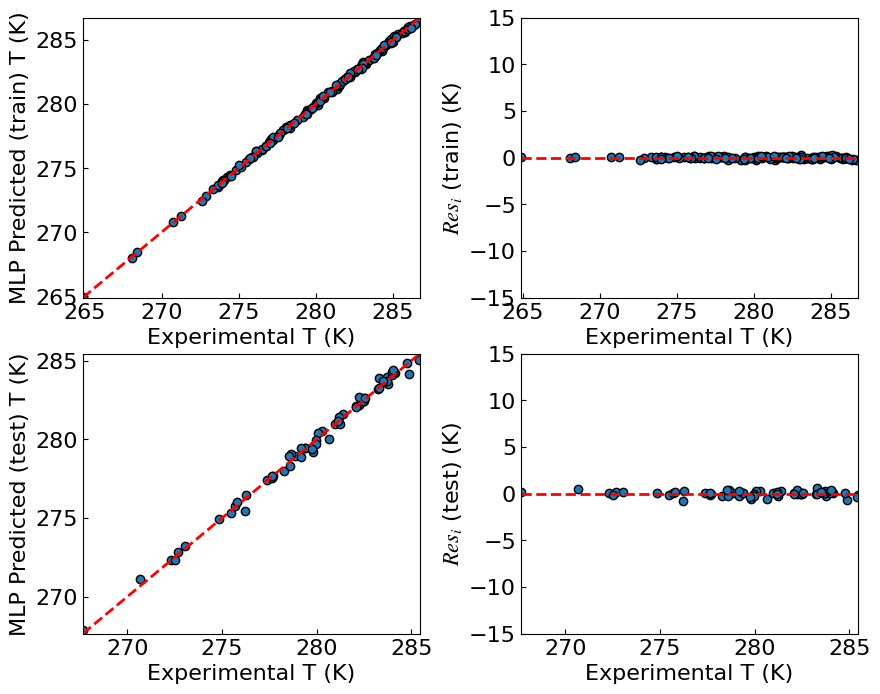

In [25]:
y_train, y_predict, y_val, y_predict_val = y_train.reshape(-1,1), y_predict.reshape(-1,1), y_val.reshape(-1,1), y_predict_val.reshape(-1,1)
def plot_figs(y_train, y_predict, y_val, y_predict_val):
	fig = fd.add_fig(figsize=(10,8),size=16)
	plt.subplots_adjust(wspace=0.3)

	ax = fd.add_ax(fig,subplot=(2,2,1))
	ax.scatter(y_train,y_predict,edgecolors=(0, 0, 0))
	ax.plot([y_train.min(),y_train.max()],[y_train.min(),y_train.max()],'r--',lw=2)
	ax.set_xlim(y_train.min(),y_train.max())
	ax.set_ylim(y_train.min(),y_train.max())
	ax.set_xlabel("Experimental T (K)")
	ax.set_ylabel("MLP Predicted (train) T (K)")

	ay = fd.add_ax(fig,subplot=(2,2,2))
	ay.scatter(y_train,y_predict-y_train,edgecolors=(0, 0, 0))
	ay.plot([y_train.min(),y_train.max()],[0,0],'r--',lw=2)
	ay.set_xlim(y_train.min(),y_train.max())
	ay.set_ylim(-15,15)
	ay.set_xlabel("Experimental T (K)")
	ay.set_ylabel(r"$\regular \it Res_i$ (train) (K)")
	# ----------- test ------------
	az = fd.add_ax(fig,subplot=(2,2,3))
	az.scatter(y_val,y_predict_val,edgecolors=(0, 0, 0))
	az.plot([y_val.min(),y_val.max()],[y_val.min(),y_val.max()],'r--',lw=2)
	az.set_xlim(y_val.min(),y_val.max())
	az.set_ylim(y_val.min(),y_val.max())
	az.set_xlabel("Experimental T (K)")
	az.set_ylabel("MLP Predicted (test) T (K)")

	aa = fd.add_ax(fig,subplot=(2,2,4))
	aa.scatter(y_val,y_predict_val-y_val,edgecolors=(0, 0, 0))
	aa.plot([y_val.min(),y_val.max()],[0,0],'r--',lw=2)
	aa.set_xlim(y_val.min(),y_val.max())
	aa.set_ylim(-15,15)
	aa.set_xlabel("Experimental T (K)")
	aa.set_ylabel(r"$\regular \it Res_i$ (test) (K)")
	plt.savefig("./imgs/MLP.png",dpi=300)
	plt.show()

	return

plot_figs(y_train, y_predict, y_val, y_predict_val)
